# Лабораторная работа №4

Лабораторная работа построена на фреймворках:

* [Keras](https://keras.io/guides) для построения нейронных сетей;
* [matplotlib](https://matplotlib.org/stable/tutorials/index.html) для работы с графиками;
* [numpy](https://numpy.org/doc/stable/) для работы с матрицами и векторами;
* [sklearn](https://scikit-learn.org/stable/user_guide.html) для тонкой настройки параметров с помощью кросс-валидации.

Для начала подключим необходимые библиотеки.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from sklearn import datasets, model_selection
from collections import namedtuple
import timeit

mpl.rcParams['axes.grid'] = True

class MyDataset:
    def __init__(self, *args):
        assert len(args) == 2 or len(args) == 4, 'x_train, x_test, y_train, y_test or (x_train, y_train), (x_test, y_test)'
        if len(args) == 2:
            (self.x_train, self.y_train), (self.x_test, self.y_test) = args
        else:
            self.x_train, self.x_test, self.y_train, self.y_test = args
    
    @property
    def train(self):
        return (self.x_train, self.y_train)
    
    @property
    def test(self):
        return (self.x_test, self.y_test)

print("tensorflow =", tf.__version__, "keras =", keras.__version__)
if tuple(map(int, tf.__version__.split('.'))) < (2, 5, 0):
    tf.autograph.set_verbosity(0)
    import logging
    logging.getLogger("tensorflow").setLevel(logging.ERROR)

tensorflow = 2.6.0 keras = 2.6.0


## Часть №1. Разработка компонентов нейронной сети

Первая часть посвящена разработке слоёв нейронной сети.
Заранее будет определён класс `MyModel` для работы с моделью нейронной сети.
Целью этого класса является:

* Объединение всех слоёв в единую структуру.
* Организация обратного распространения ошибки.
* Отслеживание метрики штрафа и точности.
* Использование оптимизатора для уточнения весов сети (в данной работе будет использоваться градиентный спуск).
* Клонирование модели для поиска гиперпараметров сети методом кросс-валидации.

In [ ]:
class MyModel(keras.Model):
    @tf.function
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=0)

        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def clone(self):
        clone_ = lambda x: x.from_config(x.get_config())
        
        model = keras.models.clone_model(self)
        model.set_weights(self.get_weights())
        metrics = [clone_(x) for x in self.compiled_metrics._metrics]
        model.compile(optimizer=clone_(self.optimizer), loss=clone_(self.loss), metrics=metrics)
        return model

### Линейный слой

Разработайте модель линейного слоя.
Перемножение матриц осуществляется с помощью функции `tf.matmul`.

In [ ]:
class MyLayer(keras.layers.Layer):
    def __init__(self, units, seed, **kwargs):
        super(MyLayer, self).__init__(**kwargs)
        self.units_ = units
        self.seed_ = seed

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units_), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(self.units_,), initializer='random_normal', trainable=True)

    @tf.function
    def call(self, inputs, training=False):
        return tf.matmul(inputs, self.w) + self.b # tf.matmul
    
    def get_config(self):
        return {**super(MyLayer, self).get_config(), 'units': self.units_, 'seed': self.seed_}

# Тестирование

mylayer_test = MyLayer(20, seed=56)

assert mylayer_test(keras.Input(shape=(100,))).shape[1] == 20, 'Не поддержан метод build'
assert mylayer_test(tf.ones([3000, 100])).shape == (3000, 20), 'Не сохраняются веса после вызова метода build'

w = mylayer_test.get_weights()
assert len(w) == 2, 'Веса деляется на коэффициенты и смещения'
assert w[0].shape == (100, 20), 'Неправильное количество коэффициентов'
assert w[1].shape == (20,), 'Неправильно количество смещений'

### Градиентный спуск

В качестве оптимизатора градиентов будем использовать градиентный спуск.
Реализуйте его в следующем классе.
В качестве возращаемого значения используйте конструкцию `var.assign(...)`, в которую дожна помещаться формула градиентного спуска.

In [ ]:
class GradDescent(keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.01, name="GradDescent", **kwargs):
        super(GradDescent, self).__init__(name, **kwargs)
        self._set_hyper("learning_rate", kwargs.get("learning_rate", learning_rate))
        self._set_hyper("decay", self._initial_decay)
    
    def _resource_apply_dense(self, grad, var, apply_state=None):
        lr = self._decayed_lr(var.dtype.base_dtype)
        return var.assign(var - lr * grad)
    
    def get_config(self):
        return {**super(GradDescent, self).get_config(), 'learning_rate': self._serialize_hyperparameter("learning_rate")}

### Подготовка датасета

Разрабатывать нейросеть будем на распространённом датасете `mnist`.
Загрузка обучающей и тестовой выборок осуществляется с помощью метода `load_data` из библиотеки `keras.datasets.mnist`.

In [ ]:
d1 = MyDataset(*keras.datasets.mnist.load_data())

print(f"Размерности: x_train={d1.x_train.shape}:{d1.x_train.dtype}, y_train={d1.y_train.shape}:{d1.y_train.dtype}, x_test={d1.x_test.shape}, y_test={d1.y_test.shape}")

d1.x_train = d1.x_train.reshape(-1, np.prod(d1.x_train.shape[1:])) / 255.0
d1.x_test = d1.x_test.reshape(-1, np.prod(d1.x_test.shape[1:])) / 255.0

print(f"Размерности после преобразования: x_train={d1.x_train.shape}, y_train={set(d1.y_train)}")

Размерности: x_train=(60000, 28, 28):uint8, y_train=(60000,):uint8, x_test=(10000, 28, 28), y_test=(10000,)
Размерности после преобразования: x_train=(60000, 784), y_train={0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


Вопросы:

1. Каков размер обучающей выборки?
1. Какую оригинальную размерность имеет каждый обучающий вектор?
1. Каков размер тестовой выборки?
1. Какую размерность и значения имеет целевой вектор?

Ответы

1. Размер обучающей выборки составляет 60000 векторов.
1. Оригинальная размерность обучающих векторов - 28x28 (до преобразования), после преобразования - 784.
1. Размер тестовой выборки составляет 10000 векторов.
1. Целевой вектор имеет размерность 1, и может принимать значения из множества $\left\{0, 1, 2, 3, 4, 5, 6, 7, 8, 9\right\}$

### Определение архитектуры нейронной сети

Для определения архитектуры нейронной сети будем использовать объектный подход, который заключается в следующем.
Создаём абстрактные данные (входной слой) нужной размерности, но без уточнения количества векторов.
Рекурсивно вызываем все слои, входом которых будет выход с предыдущего слоя.
После этого создаём модель, входом которой являются абстрактные данные, созданные вначале, а выходом является выход самого последнего слоя.
Далее модель компилируется с помощью задания оптимизатора градиентного спуска (optimizer), функции потерь (loss) и функций метрик (metrics).
Полученную модель будем использовать как прототип, чтобы иметь возможность сбрасывать до первоначального состояния значения всех весов и гиперпараметров нейронной сети.

In [ ]:
inputs = keras.Input(shape=(d1.x_train.shape[-1],), name="digits")
x = MyLayer(len(set(d1.y_train)), seed=42, name="layer_1")(inputs)
outputs = keras.layers.Activation(keras.activations.softmax, name="softmax_1")(x)

mproto = MyModel(inputs=inputs, outputs=outputs)
mproto.compile(optimizer=GradDescent(0.1),
               loss=keras.losses.SparseCategoricalCrossentropy(),
               metrics=[keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

mproto.summary()

Model: "my_model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
digits (InputLayer)          [(None, 784)]             0         
_________________________________________________________________
layer_1 (MyLayer)            (None, 10)                7850      
_________________________________________________________________
softmax_1 (Activation)       (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


Вопросы:

1. Какова размерность входных данных нейронной сети?
1. Сколько всего параметров у нейронной сети?
1. Сколько слоёв имеет нейронная сеть?

Ответы:

1. Размерность входных данных сети равна 784.
1. Всего сеть имеет 7850 параметров.
1. Сеть имеет 3 слоя (если мы учитываем входной слой и слой активации, которые в TensorFlow считаются отдельными слоями).

### Запуск полученной модели

Обучение нейронной сети осуществляется с помощью метода `fit`.
С помощью параметра `verbose` можно регулировать степень логирования процесса обучения.
В примере будем использовать параметр `validation_data`, который используется для запуска модели на переданных данных для получения метрик качества.
Параметр подразумевает, что будуте переданы валидационные данные, однако мы будем передавать туда наши тестовые векторы.
Мы можем так делать, потому что в данной модели валидационные данные **не влияют на обучение**.
Чтобы разобраться в отличии валидационных данных от тестовых, советуем ознакомиться с [этой дискуссией](https://github.com/keras-team/keras/issues/1753).

Постройте графики зависимости функции штрафа от количества эпох и точность классификации от количества эпох для обучающей и тестовой выборок.

Epoch 1/10
938/938 [==============================] - 2s 2ms/step - loss: 0.4812 - accuracy: 0.8723 - val_loss: 0.3365 - val_accuracy: 0.9078
Epoch 2/10
938/938 [==============================] - 2s 2ms/step - loss: 0.3386 - accuracy: 0.9049 - val_loss: 0.3093 - val_accuracy: 0.9141
Epoch 3/10
938/938 [==============================] - 2s 2ms/step - loss: 0.3155 - accuracy: 0.9112 - val_loss: 0.2953 - val_accuracy: 0.9167
Epoch 4/10
938/938 [==============================] - 2s 2ms/step - loss: 0.3032 - accuracy: 0.9146 - val_loss: 0.2888 - val_accuracy: 0.9199
Epoch 5/10
938/938 [==============================] - 2s 2ms/step - loss: 0.2951 - accuracy: 0.9176 - val_loss: 0.2853 - val_accuracy: 0.9198
Epoch 6/10
938/938 [==============================] - 2s 2ms/step - loss: 0.2894 - accuracy: 0.9187 - val_loss: 0.2798 - val_accuracy: 0.9218
Epoch 7/10
938/938 [==============================] - 2s 2ms/step - loss: 0.2850 - accuracy: 0.9206 - val_loss: 0.2814 - val_accuracy: 0.9223
Epoch 

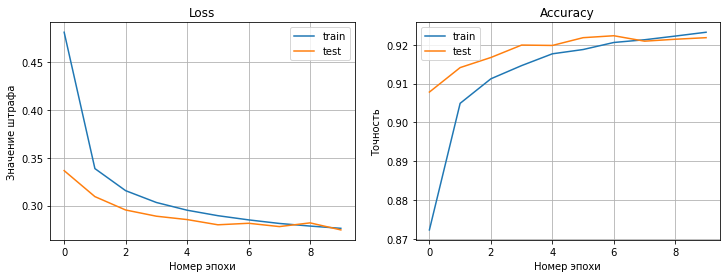

In [ ]:
%%time
model = mproto.clone()
history = model.fit(*d1.train, batch_size=64, epochs=10, verbose=1, validation_data=d1.test)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(2*6, 4))
ax0.plot(history.history['loss'], label='train')
ax0.plot(history.history['val_loss'], label='test')
ax0.set(xlabel='Номер эпохи', ylabel='Значение штрафа', title='Loss')
ax0.legend()
ax1.plot(history.history['accuracy'], label='train')
ax1.plot(history.history['val_accuracy'], label='test')
ax1.set(xlabel='Номер эпохи', ylabel='Точность', title='Accuracy')
ax1.legend()

print(dict(zip(model.metrics_names, model.evaluate(*d1.test, verbose=0))))

Вопросы:

1. Сколько итераций было за эпоху?
1. Сколько использовалось векторов в одной итерации?
1. Какой точности удалось достичь?
1. Опишите поведение функции потерь и точности для обучающей и тестовой последовательностям. Насколько они похожи?
1. Есть ли переобучение модели?

Ответы:

1. 938 итераций за 1 эпоху.
1. 64 вектора (размер батча).
1. Удалось достичь $92\%$ точности.

Покажите, что получается на выходе нейронной сети, построив графики распределения ответов на последнем слое.
Также покажите на хит-мапе корреляцию ответов нейронной сети с реальными данными.

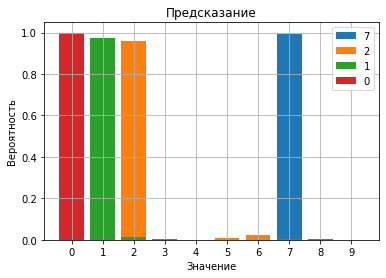

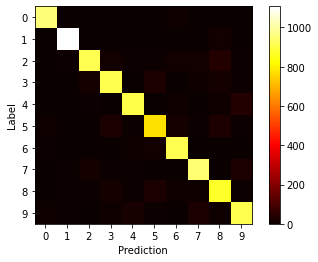

In [ ]:
p = model.predict(d1.x_test)
for idx, pp in enumerate(p[:4]):
    plt.bar(np.arange(0, 10), pp, label=d1.y_test[idx])

plt.xlabel('Значение')
plt.ylabel('Вероятность')
plt.title('Предсказание')
plt.xticks(np.arange(0, 10))
plt.legend()

plt.figure()
plt.imshow(tf.math.confusion_matrix(d1.y_test, p.argmax(axis=1)), cmap='hot')
plt.colorbar()
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.xticks(list(set(d1.y_test)))
plt.yticks(list(set(d1.y_test)))
plt.grid(False)

In [ ]:
tf.math.confusion_matrix(d1.y_test, p.argmax(axis=1))

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 957,    0,    2,    2,    0,    5,   11,    1,    2,    0],
       [   0, 1110,    2,    2,    0,    2,    4,    2,   13,    0],
       [   4,   10,  917,   14,   10,    7,   12,   10,   39,    9],
       [   3,    0,   21,  904,    0,   38,    2,   10,   17,   15],
       [   1,    2,    2,    1,  918,    0,   11,    2,    7,   38],
       [  10,    3,    2,   23,    9,  790,   15,    6,   27,    7],
       [   8,    3,    4,    2,   10,   15,  911,    3,    2,    0],
       [   2,    7,   22,    7,    7,    1,    0,  942,    2,   38],
       [   6,    7,    7,   17,    9,   35,   10,   10,  862,   11],
       [   9,    6,    2,    8,   36,    8,    0,   15,    8,  917]],
      dtype=int32)>

Вопросы:

1. Что является выходом нейронной сети?
1. Какие значения принимает `y_train`?
1. Как нейронная сеть сравнивает свой выход с `y_train`?
1. Какая цифра распознаётся лучше всех, а какая хуже всех?

Ответы:

1. Выход нейронной сети - набор векторов вероятностей соответствия заданным 10 классам. Каждый вектор в выходном наборе соответствует вектору во входном наборе.
1. `y_train` принимает значения из множества $\left\{0, 1, 2, 3, 4, 5, 6, 7, 8, 9\right\}$.
1. Номер наибольшего элемента вектора вероятностей сравнивается со значением соотвествующей метки из `y_train`.
1. Лучше всех распознаётся цифра $1$, хуже всех - цифра $5$.

## Часть №2. Поиск оптимальных гиперпараметров нейронной сети

В этой части рассмотрим как происходит настройка гиперпараметров нейронной сети.
Гиперпараметр является лучшим, если при нём нейросеть показывает наилучшие характеристике на _тестовом_ датасете.
Тестирование во время обучения осуществляется с помощью механизма кросс-валидации.

### Загрузка датасета

Для демонстрации поиска параметров нейронной сети будем использовать искусственный датасет.
Получить его можно функцией `sklearn.datasets.make_classification`.
Параметры функции можно посмотреть в документации.
Нас пока будут интересовать параметры:

* `n_samples` - количество векторов обучения;
* `n_classes` - количество классов для классификации;
* `random_state` - для повторяемости генерации датасета;
* остальные параметры нужны для балансировки датасета.

x_train=(800, 2), y_train=(800,):{0, 1}, x_test=(200, 2)


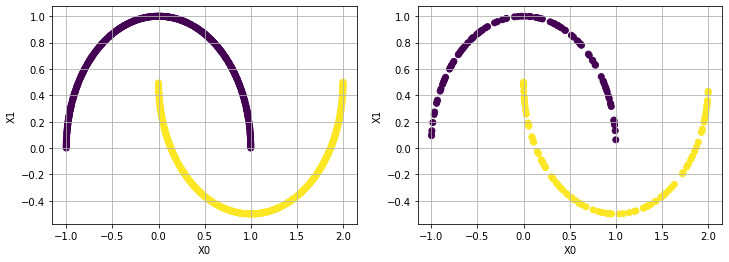

In [ ]:
x, y = sk.datasets.make_moons(n_samples=1000, random_state=1)
d2 = MyDataset(*sk.model_selection.train_test_split(x, y, test_size=0.2))

print(f"x_train={d2.x_train.shape}, y_train={d2.y_train.shape}:{set(d2.y_train)}, x_test={d2.x_test.shape}")
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
for x, y, ax in [(d2.x_train, d2.y_train, ax0), (d2.x_test, d2.y_test, ax1)]:
    ax.scatter(x[:, 0], x[:, 1], c=y)
    ax.set(xlabel='X0', ylabel='X1')

### Поиск оптимальных параметров сети

Создание модели помещено в функцию, чтобы можно было "клонировать" нейронную сеть с изменёнными параметрами.
Параметр `batch_size` не входит в саму сеть, он будет подставляться уже при запуске обучения.

In [ ]:
def create_model(units=50, activation='relu', lr=0.1):
    inputs = keras.Input(shape=(d2.x_train.shape[-1],))
    x = MyLayer(units, seed=49)(inputs)
    x = keras.layers.Activation(activation)(x)
    x = MyLayer(1, seed=75)(x)
    outputs = keras.layers.Activation(keras.activations.sigmoid)(x)

    model = MyModel(inputs, outputs)
    model.compile(GradDescent(lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model

params = {'lr': np.logspace(-2, 1.3, 7),
          'units': [2, 5, 10, 50, 100, 500, 1000],
          'batch_size': [1, 16, 64, 128, 1024],
          'activation': ['relu', 'tanh', 'softmax', 'sigmoid']
         }

#### Исследование коэффициента скорости поиска

Переберите все параметры коэффициента скорости градиентного спуска `lr` и постройте графики:
* зависимость функции штрафа от номера эпохи,
* зависимость точности классификации от номера эпохи для обучающей и тестовой выборок.

CPU times: user 44.6 s, sys: 3.09 s, total: 47.7 s
Wall time: 52.6 s


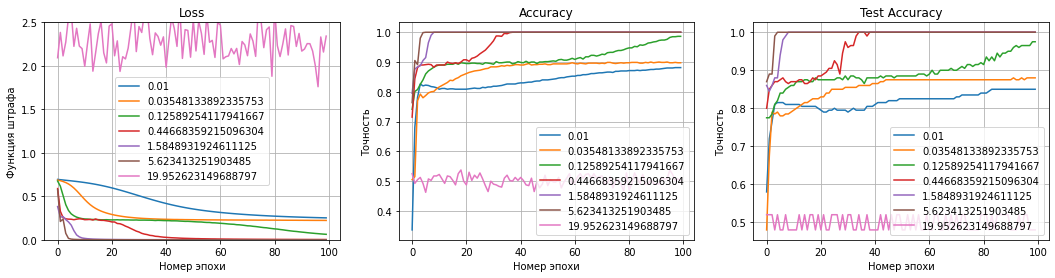

In [ ]:
%%time
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(3*6, 4))
for p in params['lr']:
    model = create_model(lr=p)
    history = model.fit(*d2.train, validation_data=d2.test, epochs=100, verbose=0)
    ax0.plot(history.history['loss'], label=p)
    ax0.set(xlabel='Номер эпохи', ylabel='Функция штрафа', title='Loss', ylim=[0, 2.5])
    ax0.legend()
    ax1.plot(history.history['accuracy'], label=p)
    ax1.set(xlabel='Номер эпохи', ylabel='Точность', title='Accuracy')
    ax1.legend()
    ax2.plot(history.history['val_accuracy'], label=p)
    ax2.set(xlabel='Номер эпохи', ylabel='Точность', title='Test Accuracy')
    ax2.legend()

Увеличим количество эпох до 1000.

CPU times: user 6min 36s, sys: 30 s, total: 7min 7s
Wall time: 6min 53s


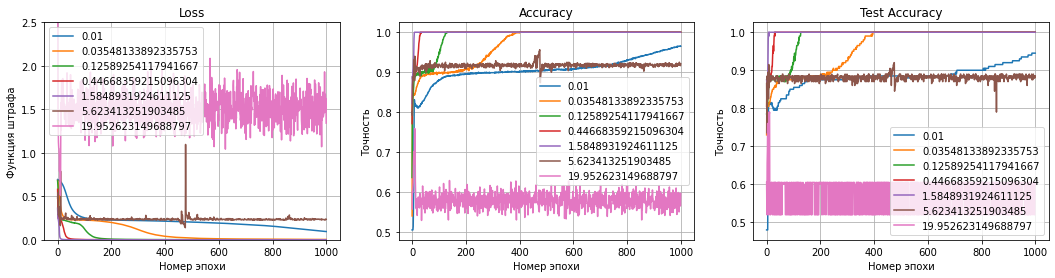

In [ ]:
%%time
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(3*6, 4))
for p in params['lr']:
    model = create_model(lr=p)
    history = model.fit(*d2.train, validation_data=d2.test, epochs=1000, verbose=0)
    ax0.plot(history.history['loss'], label=p)
    ax0.set(xlabel='Номер эпохи', ylabel='Функция штрафа', title='Loss', ylim=[0, 2.5])
    ax0.legend()
    ax1.plot(history.history['accuracy'], label=p)
    ax1.set(xlabel='Номер эпохи', ylabel='Точность', title='Accuracy')
    ax1.legend()
    ax2.plot(history.history['val_accuracy'], label=p)
    ax2.set(xlabel='Номер эпохи', ylabel='Точность', title='Test Accuracy')
    ax2.legend()

Вопросы:

1. Что было бы, если бы в примере было гораздо больше эпох (можно поэкспериментировать с количеством эпох)?
1. При всех ли коэффициентах `lr` достигается 100% точность (нулевая функция потерь)?
1. Сформулируйте правило: чем больше значение `lr`, тем скорость обучения выше/ниже?

Ответы:

1. При увеличении количества эпох некоторым моделям удаётся достичь больших значений точности.
1. Нет, не при всех. По графикам видно, что кривые, соотвествующие двум наибольшим значеням lr, не способны достигнуть $100\%$ точности даже спустя 1000 эпох обучения.
1. Чем больше значение lr, тем выше скорость обучения, что можно видеть по графикам кривых, за исключением двух, соотвествующих двум наибольшим значеням lr. Поэтому стоит отметить, что при очень больших значениях lr может получиться так, что веса не сойдутся к оптимальным значениям.

#### Исследование размера скрытого слоя

Размером скрытого слоя будем называть количество содержащихся в нём нейронов.
Изучим, как количество нейронов в скрытом слое влияет на точность и скорость обучения.
Постройте графики зависимостей:

* функции потерь от номера эпохи;
* точность классификации от номера эпохи для обучающей и тестовой выборок;
* время обучения модели от количества нейронов.

CPU times: user 46.1 s, sys: 3.17 s, total: 49.3 s
Wall time: 1min 6s


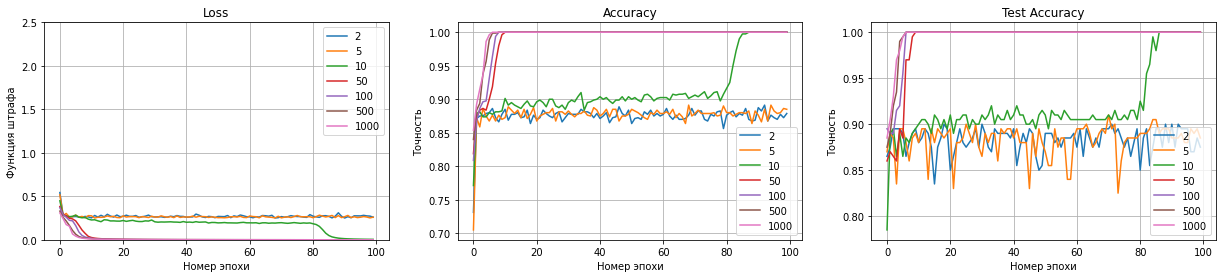

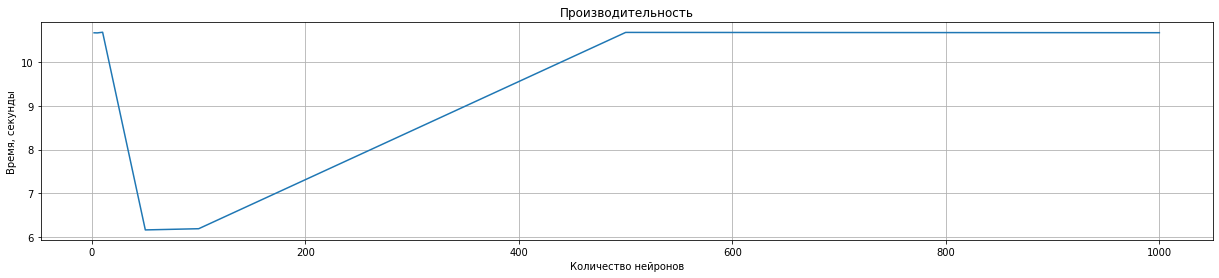

In [ ]:
%%time
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(3*7, 4))
layer_timer = {}
for p in params['units']:
    model = create_model(units=p, lr=1.5)
    t = timeit.default_timer()
    history = model.fit(*d2.train, validation_data=d2.test, epochs=100, verbose=0)
    layer_timer[p] = timeit.default_timer() - t
    ax0.plot(history.history['loss'], label=p)
    ax0.set(xlabel='Номер эпохи', ylabel='Функция штрафа', title='Loss', ylim=[0, 2.5])
    ax0.legend()
    ax1.plot(history.history['accuracy'], label=p)
    ax1.set(xlabel='Номер эпохи', ylabel='Точность', title='Accuracy')
    ax1.legend()
    ax2.plot(history.history['val_accuracy'], label=p)
    ax2.set(xlabel='Номер эпохи', ylabel='Точность', title='Test Accuracy')
    ax2.legend()

plt.figure(figsize=(3*7, 4))
plt.xlabel('Количество нейронов')
plt.ylabel('Время, секунды')
plt.title('Производительность')
plt.plot(list(layer_timer.keys()), list(layer_timer.values())) # python3.7+

Вопросы:

1. Как связаны скорость обучения и размер скрытого слоя?
1. Как связаны время обучения (секунды, потраченные на обучение) и размер скрытого слоя?
1. Что наблюдается при очень малом количестве нейронов в скрытом слое?
1. Что наблюдается при очень большом количестве нейронов в скрытом слое?

Ответы:

1. Чем больше нейронов, тем меньше эпох требуется для достижения итоговой точности.
1. С увеличением размера скрытого слоя скорость обучения сначала начинает убывать (скорее всего, это связано с распараллеливанием операций за счёт использования векторных регистров), затем снова возрастает.
1. При очень малом количестве нейронов в скрытом слое (до 10) рост точности сети останавливается в районе $90\%$.
1. Для данной задачи при очень большом количестве нейронов в скрытом слое переобучения не наблюдается, вместе с тем сеть быстро (за наименьшее число эпох) настраивается под оптимальные значения весов.


#### Исследование размера батча

Размер батча определяется в методе `fit` настроенной модели параметром `batch_size`.
Постройте графики зависимостей:

* функции потерь от номера эпохи;
* точность классификации от номера эпохи для обучающей и тестовой выборок;
* время обучения модели от количества нейронов.

CPU times: user 2min 19s, sys: 12.5 s, total: 2min 31s
Wall time: 1min 57s


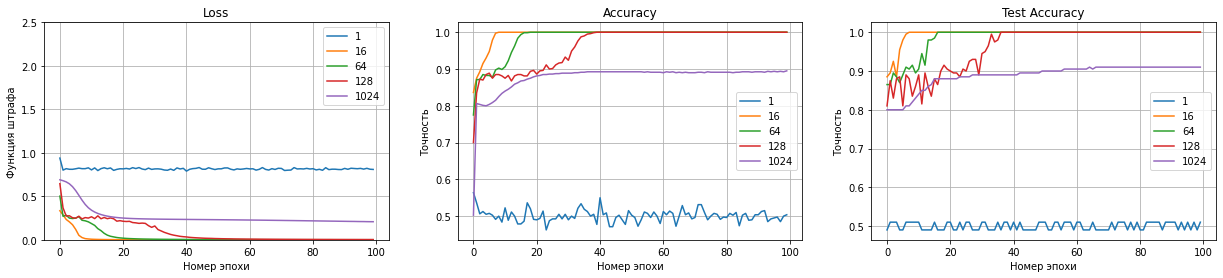

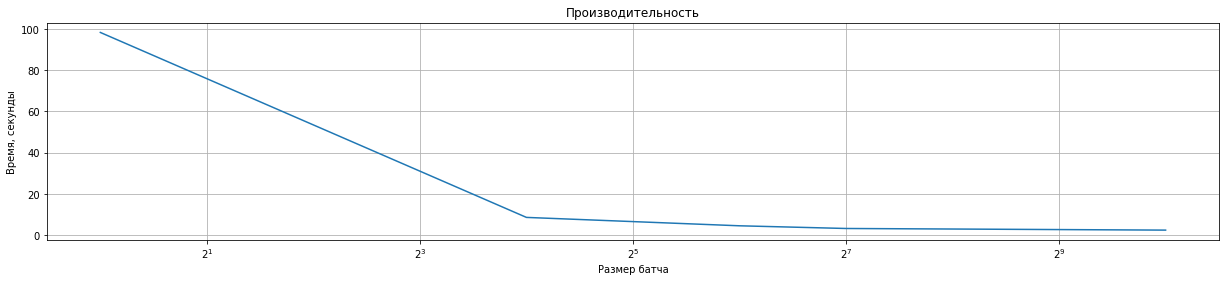

In [127]:
%%time
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(3*7, 4))
batch_timer = {}
for p in params['batch_size']:
    model = create_model(units=50, lr=1.5)
    t = timeit.default_timer()
    history = model.fit(*d2.train, validation_data=d2.test, epochs=100, batch_size=p, verbose=0)
    batch_timer[p] = timeit.default_timer() - t
    ax0.plot(history.history['loss'], label=p)
    ax0.set(xlabel='Номер эпохи', ylabel='Функция штрафа', title='Loss', ylim=[0, 2.5])
    ax0.legend()
    ax1.plot(history.history['accuracy'], label=p)
    ax1.set(xlabel='Номер эпохи', ylabel='Точность', title='Accuracy')
    ax1.legend()
    ax2.plot(history.history['val_accuracy'], label=p)
    ax2.set(xlabel='Номер эпохи', ylabel='Точность', title='Test Accuracy')
    ax2.legend()

plt.figure(figsize=(3*7, 4))
plt.xlabel('Размер батча')
plt.ylabel('Время, секунды')
plt.title('Производительность')
plt.semilogx(list(batch_timer.keys()), list(batch_timer.values()), basex = 2) # python3.7+

CPU times: user 2min 19s, sys: 12.4 s, total: 2min 32s
Wall time: 1min 59s


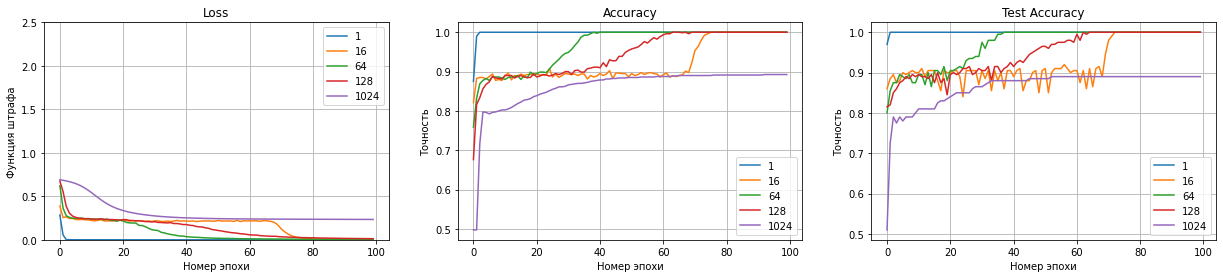

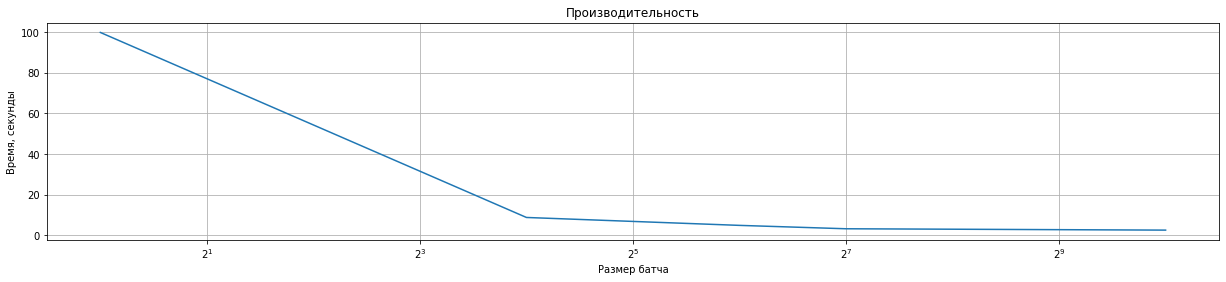

In [129]:
%%time
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(3*7, 4))
batch_timer = {}
for p in params['batch_size']:
    model = create_model(units=50, lr=0.7)
    t = timeit.default_timer()
    history = model.fit(*d2.train, validation_data=d2.test, epochs=100, batch_size=p, verbose=0)
    batch_timer[p] = timeit.default_timer() - t
    ax0.plot(history.history['loss'], label=p)
    ax0.set(xlabel='Номер эпохи', ylabel='Функция штрафа', title='Loss', ylim=[0, 2.5])
    ax0.legend()
    ax1.plot(history.history['accuracy'], label=p)
    ax1.set(xlabel='Номер эпохи', ylabel='Точность', title='Accuracy')
    ax1.legend()
    ax2.plot(history.history['val_accuracy'], label=p)
    ax2.set(xlabel='Номер эпохи', ylabel='Точность', title='Test Accuracy')
    ax2.legend()

plt.figure(figsize=(3*7, 4))
plt.xlabel('Размер батча')
plt.ylabel('Время, секунды')
plt.title('Производительность')
plt.semilogx(list(batch_timer.keys()), list(batch_timer.values()), basex = 2) # python3.7+

Вопросы:

1. При всех ли значениях размера батча достигается 100% точность на тестовой/обучающей выборках?
1. Что будет, если понизить коэффициент скорости градиентого спуска `lr`? Добейтесь, чтобы все графики выглядели "хорошо".
1. Запишите правило: чем больше размер батча, тем скорость обучения выше/ниже?
1. Что наблюдается со временем обучения (секунды, потреченные на обучение) при повышении размера батча?

Ответы:

1. Нет, не при всех. При самом большом и самом маленьком размерах батча $100\%$ точность не достигается ни на обучающей, ни на тем более тестовой выборке.
1. Если понизить коэффициент скорости `lr`, то это позволит добиться $100\%$ точности при размере батча, равном 1. При этом итоговая точность для размера батча, равном 1024, немного уменьшится, хотя всё также останется в районе $90\%$.
1. Чем больше размер батча, тем скорость обучения ниже (требуется большее количество эпох обучения).
1. При повышении размера батча время обучения уменьшается, так как в этом случае алгоритм оптимизации делает меньше итераций корректировки весов.

### Исследование функций активации скрытого слоя

Переберите функции активаций.
Постройте графики зависимостей:

* функции потерь от номера эпохи;
* точность классификации от номера эпохи для обучающей и тестовой выборок;
* время обучения модели от количества нейронов.

CPU times: user 40.9 s, sys: 3.3 s, total: 44.2 s
Wall time: 41.1 s


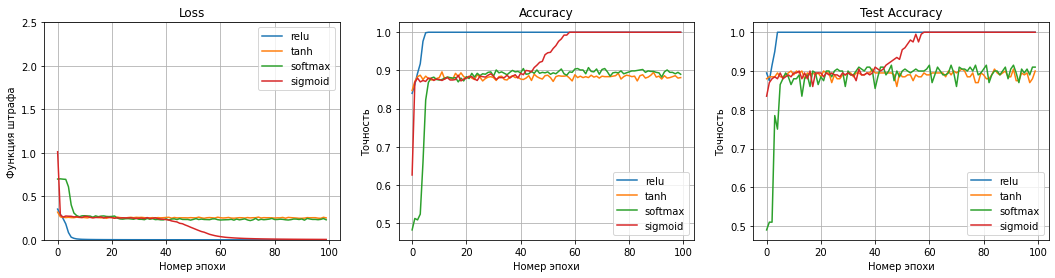

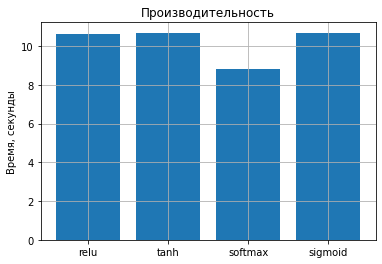

In [130]:
%%time
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(3*6, 4))
activation_timer = {}
for p in params['activation']:
    model = create_model(units=50, lr=1.5, activation=p)
    t = timeit.default_timer()
    history = model.fit(*d2.train, validation_data=d2.test, batch_size=16, epochs=100, verbose=0)
    activation_timer[p] = timeit.default_timer() - t
    ax0.plot(history.history['loss'], label=p)
    ax0.set(xlabel='Номер эпохи', ylabel='Функция штрафа', title='Loss', ylim=[0, 2.5])
    ax0.legend()
    ax1.plot(history.history['accuracy'], label=p)
    ax1.set(xlabel='Номер эпохи', ylabel='Точность', title='Accuracy')
    ax1.legend()
    ax2.plot(history.history['val_accuracy'], label=p)
    ax2.set(xlabel='Номер эпохи', ylabel='Точность', title='Test Accuracy')
    ax2.legend()

plt.figure()
plt.ylabel('Время, секунды')
plt.title('Производительность')
plt.bar(list(activation_timer.keys()), list(activation_timer.values())) # python3.7+

Вопросы:

1. При какой(их) функции активации скрытого слоя достигается максимальная точность?
1. При какой(их) функции активации скрытого слоя максимальная точности достигается быстрее всего?
1. Как влияет функция активации на время обучения (секунды, потреченные на обучение)?

Ответы:

1. ReLU, Sigmoid.
1. ReLU
1. При использовании функции активации Softmax на выходном слое на обучение требуется меньше всего времени, однако итоговая точность при этом получается в районе $90\%$.

## Часть №3. Применение Dropout

Применение dropout для решения проблем переобучения.

### Составление датасета

Подготовим датасет, который отвечает следующим критериями.

(210, 4) float64 (210,) int64 (90, 4)


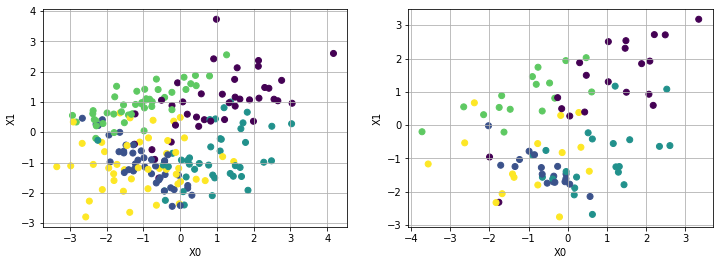

In [131]:
x, y = sk.datasets.make_classification(n_samples=300, n_classes=5, n_features=4, n_informative=3, n_redundant=0, n_clusters_per_class=1, random_state=1)
d3 = MyDataset(*sk.model_selection.train_test_split(x, y, test_size=0.3))

print(d3.x_train.shape, d3.x_train.dtype, d3.y_train.shape, d3.y_train.dtype, d3.x_test.shape)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(2*6, 4))
for x, y, ax in [(*d3.train, ax0), (*d3.test, ax1)]:
    ax.scatter(x[:, 0], x[:, 1], c=y)
    ax.set(xlabel='X0', ylabel='X1')

### Составление модели

В нейросетевой модели сделаем один скрытый слой с большим количеством нейронов.
Постройте графики зависимостей:

* функции потерь от номера эпохи для обучающей и тестовой выборок;
* точность классификации от номера эпохи для обучающей и тестовой выборок.

Model: "my_model_195"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 4)]               0         
_________________________________________________________________
linear_1 (MyLayer)           (None, 100)               500       
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
linear_end (MyLayer)         (None, 5)                 505       
_________________________________________________________________
activation_end (Activation)  (None, 5)                 0         
Total params: 1,005
Trainable params: 1,005
Non-trainable params: 0
_________________________________________________________________
{'loss': 0.7919014692306519, 'accuracy': 0.855555534362793}
CPU times: user 15.1 s, sys: 887 ms, total: 15.9 s
Wall ti

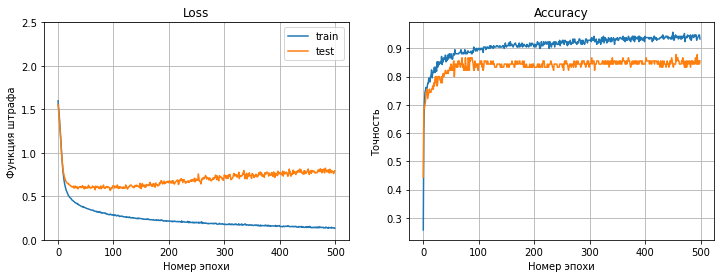

In [132]:
%%time
def create_model3():
    inputs = keras.layers.Input(shape=(d3.x_train.shape[-1],), name="inputs")
    x = MyLayer(100, seed=12, name='linear_1')(inputs)
    x = keras.layers.Activation('relu', name='activation_1')(x)
    x = MyLayer(len(set(d3.y_train)), seed=47, name='linear_end')(x)
    outputs = keras.layers.Activation('softmax', name='activation_end')(x)
    model = MyModel(inputs=inputs, outputs=outputs)
    model.compile(optimizer=GradDescent(0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model3 = create_model3()
model3.summary()
history3 = model3.fit(*d3.train, epochs=500, validation_data=d3.test, verbose=0)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(6*2, 4))
ax0.plot(history3.history['loss'], label='train')
ax0.plot(history3.history['val_loss'], label='test')
ax0.set(xlabel='Номер эпохи', ylabel='Функция штрафа', title='Loss', ylim=[0, 2.5])
ax0.legend()
ax1.plot(history3.history['accuracy'], label='train')
ax1.plot(history3.history['val_accuracy'], label='test')
ax1.set(xlabel='Номер эпохи', ylabel='Точность', title='Accuracy')

result = model3.evaluate(*d3.test, verbose=0)
print(dict(zip(model3.metrics_names, result)))

Разность точности на обучающей и тестовой выборках составляет:

In [136]:
diff = np.abs(history3.history['accuracy'][-1] - history3.history['val_accuracy'][-1])
print(diff)

0.07777780294418335


Вопросы:

1. Насколько сильно отличается точность на обучающей и тестовой выборках?
1. Наблюдается ли переобучение?

Ответы:

1. Примерно на $7.8\%$.
1. Да, по графику функции потерь видно, что с некоторого момента функция потерь на тестовом наборе данных начинает возрастать, при этом продолжая убывать на обучающем наборе.

### Разработка слоя Dropout

Реализуйте слой Dropout.
Так как этот слой применяется только при обучении модели, необходимо анализировать параметр `training`, чтобы отлючать функциональность слоя при обычном запуске модели.
Все вычисления в Tensorflow проводятся в отложенном режиме.
Это означает, что результат вычислений будет известен не в точке написания формулы, а где-нибудь в другом месте.

При разработке слоя используйте функции:

* `tf.random.uniform` - возвращает вектор случайных чисел из заданного интервала (обязательно передайте параметр `shape` и `seed`);
* возможно потребуется функция `tf.cast`, чтобы поменять тип некоторых операндов;
* примитивные операции (умножение, сложение и т.д.) можно делать так, как есть;
* над операндами можно проводить операции сравнения.

In [217]:
class MyDropout(keras.layers.Layer):
    def __init__(self, rate, seed, **kwargs):
        kwargs['trainable'] = False
        super(MyDropout, self).__init__(**kwargs)
        self.rate_ = rate
        self.scale_ = 1 / (1 - rate)
        self.seed_ = seed

    @tf.function
    def call(self, inputs, training=False):
        if training:
          if (self.rate_ <= 0.5):
            w = self.rate_
          else:
            w = self.rate_ - 1
          if (inputs.shape[0] == None):
            return ( tf.round(tf.random.uniform(shape = (tf.TensorShape(1) + inputs.shape[1:]), seed = self.seed_) + w) * inputs * self.scale_)
          else:
            return ( tf.round(tf.random.uniform(shape = inputs.shape, seed = self.seed_) + w) * inputs * self.scale_)
        else:
          return inputs
    
    def get_config(self):
        return {**super(MyDropout, self).get_config(), 'rate': self.rate_, 'seed': self.seed_}

# Тестирование

drop_test = MyDropout(0.25, 49)
t = drop_test(tf.ones([300, 10]), training=True)

assert 0.2 < len(t[t == 0]) / 3000 < 0.3, 'Вероятность dropout вне исследуемого диапазона'
assert tf.math.reduce_all(t[t != 0] == 4/3), 'Масштабирование переменных не корректно'
try:
    drop_test(keras.Input(shape=(10,)), training=True)
except:
    assert False, 'Не поддерживается частичная форма тензора'

### Составление модели с Dropout

В модель добавить слой `MyDropout`.
Необходимо выяснить закономерность параметра `rate`.
Постройте графики зависимости функции потерь и точности классификации для обучающей и тестовой выборок.
Графики сгруппируйте так: отдельно обучающая выборка, отдельно тестовая.

rate 0 {'loss': 0.8448333740234375, 'accuracy': 0.7888888716697693}
rate 0.01 {'loss': 0.8524812459945679, 'accuracy': 0.7888888716697693}
rate 0.02 {'loss': 0.8600248694419861, 'accuracy': 0.7777777910232544}
rate 0.05 {'loss': 0.8629637956619263, 'accuracy': 0.7888888716697693}
rate 0.1 {'loss': 0.8825858235359192, 'accuracy': 0.7777777910232544}
rate 0.25 {'loss': 1.002173662185669, 'accuracy': 0.7888888716697693}
rate 0.6 {'loss': 2.219611883163452, 'accuracy': 0.7666666507720947}
rate 0.9 {'loss': 3.577207326889038, 'accuracy': 0.5777778029441833}
CPU times: user 2min, sys: 7.22 s, total: 2min 8s
Wall time: 2min 19s


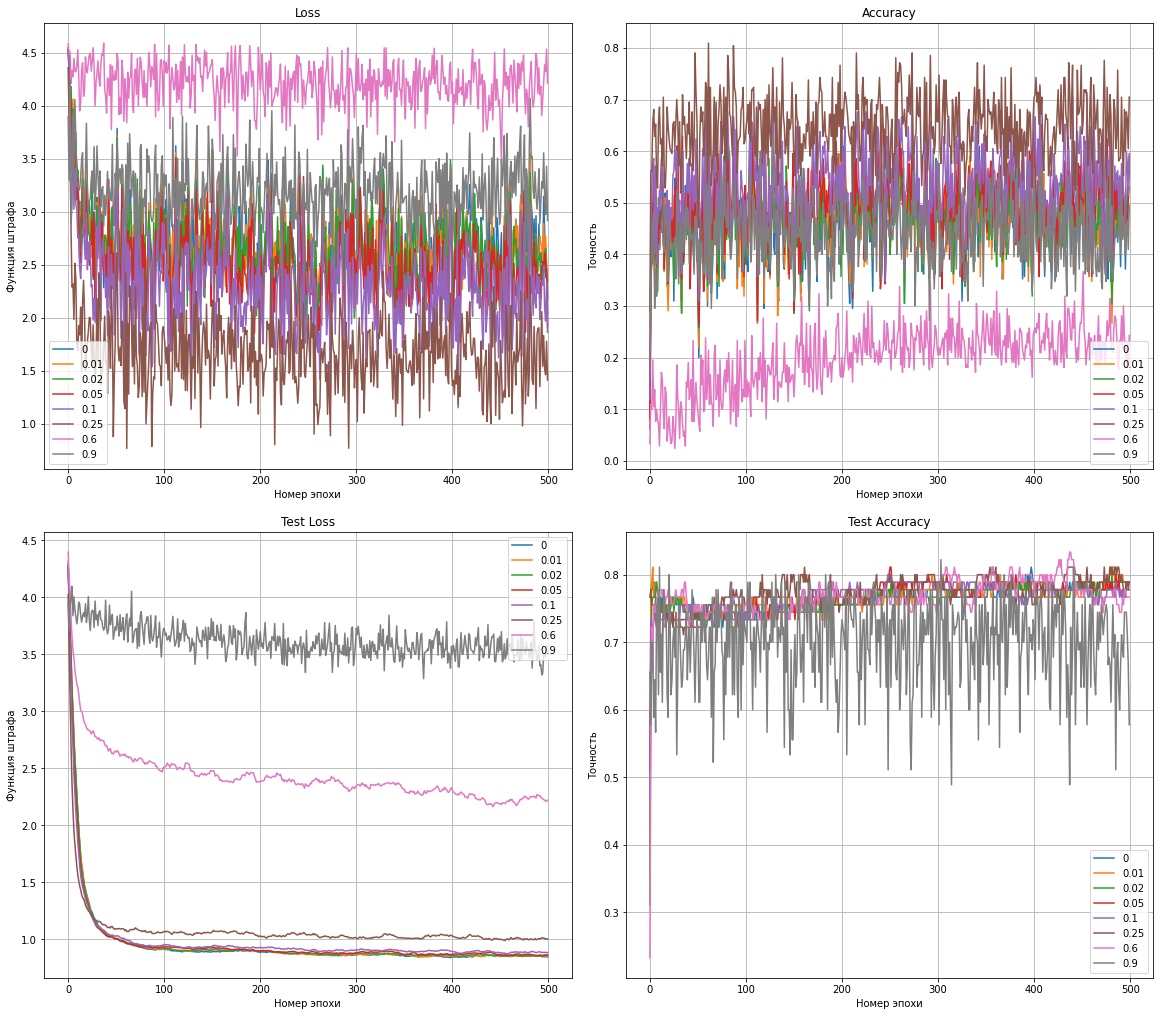

In [234]:
%%time
def create_model32(rate):
    inputs = keras.layers.Input(shape=(d3.x_train.shape[-1],), name="inputs")
    x = MyLayer(100, seed=12, name='linear_1')(inputs)
    x = MyDropout(rate, 49)(x)
    #x = tf.keras.layers.Dropout(rate = rate, seed = 49)(x)
    outputs = keras.layers.Activation('softmax', name='activation_end')(x)
    model = MyModel(inputs=inputs, outputs=outputs)
    model.compile(optimizer=GradDescent(0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

fig, ((ax0, ax2), (ax1, ax3)) = plt.subplots(2, 2, figsize=(2*8, 2*7), constrained_layout=True)
for p in [0, 0.01, 0.02, 0.05, 0.1, 0.25, 0.6, 0.9]:
    model = create_model32(rate=p)
    history = model.fit(*d3.train, validation_data=d3.test, epochs=500, verbose=0)
    print('rate', p, dict(zip(model.metrics_names, model.evaluate(*d3.test, verbose=0))))
    ax0.plot(history.history['loss'], label=p)
    ax0.set(xlabel='Номер эпохи', ylabel='Функция штрафа', title='Loss')
    ax0.legend()
    ax1.plot(history.history['val_loss'], label=p)
    ax1.set(xlabel='Номер эпохи', ylabel='Функция штрафа', title='Test Loss')
    ax1.legend()
    ax2.plot(history.history['accuracy'], label=p)
    ax2.set(xlabel='Номер эпохи', ylabel='Точность', title='Accuracy')
    ax2.legend()
    ax3.plot(history.history['val_accuracy'], label=p)
    ax3.set(xlabel='Номер эпохи', ylabel='Точность', title='Test Accuracy')
    ax3.legend()
   

Попробуем другие значения rate:

rate 0.2 {'loss': 0.9536309838294983, 'accuracy': 0.7777777910232544}
rate 0.25 {'loss': 0.9957081079483032, 'accuracy': 0.800000011920929}
rate 0.3 {'loss': 1.0620368719100952, 'accuracy': 0.8111110925674438}
rate 0.35 {'loss': 1.1339775323867798, 'accuracy': 0.8111110925674438}
rate 0.4 {'loss': 1.187609314918518, 'accuracy': 0.8222222328186035}
rate 0.45 {'loss': 1.2274699211120605, 'accuracy': 0.8222222328186035}
rate 0.5 {'loss': 0.9161300659179688, 'accuracy': 0.8333333134651184}
rate 0.55 {'loss': 2.189075469970703, 'accuracy': 0.800000011920929}
rate 0.6 {'loss': 2.163762092590332, 'accuracy': 0.800000011920929}
rate 0.65 {'loss': 2.3231616020202637, 'accuracy': 0.7888888716697693}
rate 0.7 {'loss': 2.50264835357666, 'accuracy': 0.7888888716697693}
CPU times: user 5min 2s, sys: 16.1 s, total: 5min 18s
Wall time: 6min 29s


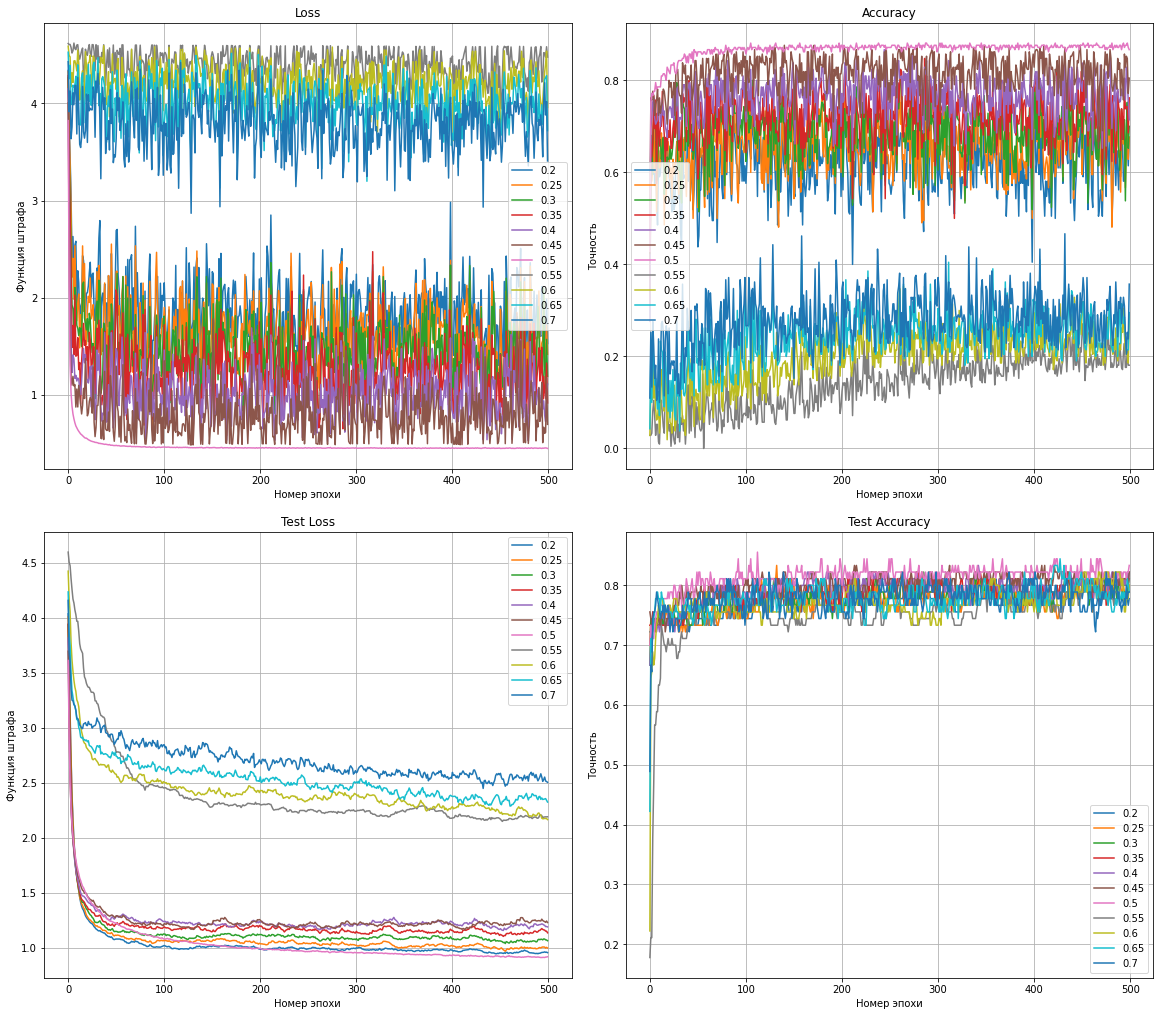

In [235]:
%%time
def create_model32(rate):
    inputs = keras.layers.Input(shape=(d3.x_train.shape[-1],), name="inputs")
    x = MyLayer(100, seed=12, name='linear_1')(inputs)
    x = MyDropout(rate, 49)(x)
    #x = tf.keras.layers.Dropout(rate = rate, seed = 49)(x)
    outputs = keras.layers.Activation('softmax', name='activation_end')(x)
    model = MyModel(inputs=inputs, outputs=outputs)
    model.compile(optimizer=GradDescent(0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

fig, ((ax0, ax2), (ax1, ax3)) = plt.subplots(2, 2, figsize=(2*8, 2*7), constrained_layout=True)
for p in [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]:
    model = create_model32(rate=p)
    history = model.fit(*d3.train, validation_data=d3.test, epochs=500, verbose=0)
    print('rate', p, dict(zip(model.metrics_names, model.evaluate(*d3.test, verbose=0))))
    ax0.plot(history.history['loss'], label=p)
    ax0.set(xlabel='Номер эпохи', ylabel='Функция штрафа', title='Loss')
    ax0.legend()
    ax1.plot(history.history['val_loss'], label=p)
    ax1.set(xlabel='Номер эпохи', ylabel='Функция штрафа', title='Test Loss')
    ax1.legend()
    ax2.plot(history.history['accuracy'], label=p)
    ax2.set(xlabel='Номер эпохи', ylabel='Точность', title='Accuracy')
    ax2.legend()
    ax3.plot(history.history['val_accuracy'], label=p)
    ax3.set(xlabel='Номер эпохи', ylabel='Точность', title='Test Accuracy')
    ax3.legend()

Повторим эксперимент со слоем `tf.keras.layers.Dropout` библиотеки TensorFlow:

rate 0.2 {'loss': 0.9286608099937439, 'accuracy': 0.8111110925674438}
rate 0.25 {'loss': 1.0092179775238037, 'accuracy': 0.800000011920929}
rate 0.3 {'loss': 1.0937824249267578, 'accuracy': 0.7888888716697693}
rate 0.35 {'loss': 1.1607884168624878, 'accuracy': 0.7666666507720947}
rate 0.4 {'loss': 1.2890081405639648, 'accuracy': 0.7777777910232544}
rate 0.45 {'loss': 1.4349184036254883, 'accuracy': 0.7888888716697693}
rate 0.5 {'loss': 1.5607473850250244, 'accuracy': 0.7777777910232544}
rate 0.55 {'loss': 1.7797876596450806, 'accuracy': 0.7666666507720947}
rate 0.6 {'loss': 1.9166431427001953, 'accuracy': 0.7888888716697693}
rate 0.65 {'loss': 2.140652894973755, 'accuracy': 0.7777777910232544}
rate 0.7 {'loss': 2.407252073287964, 'accuracy': 0.7555555701255798}
CPU times: user 4min 21s, sys: 14.1 s, total: 4min 35s
Wall time: 5min 2s


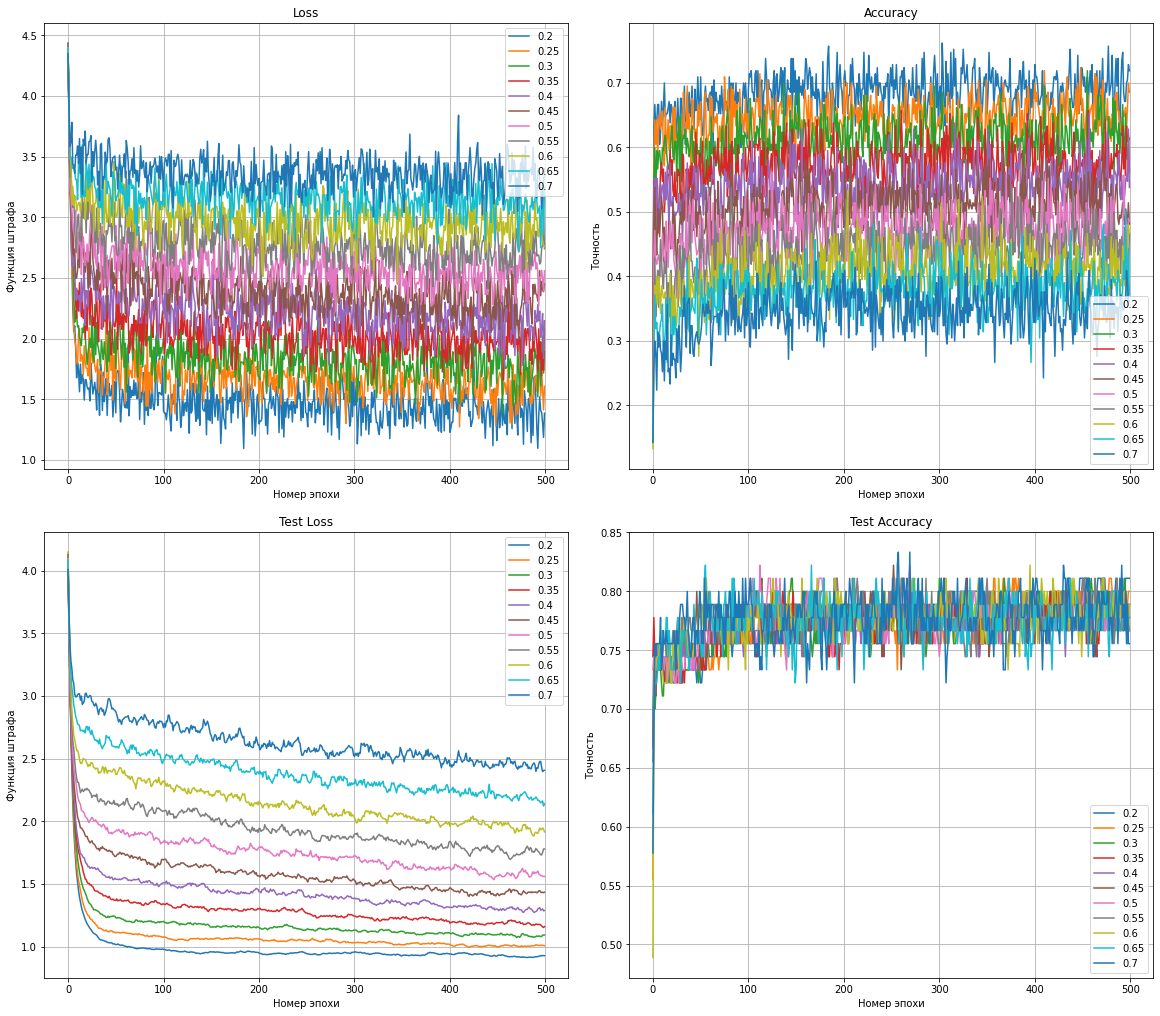

In [236]:
%%time
def create_model32(rate):
    inputs = keras.layers.Input(shape=(d3.x_train.shape[-1],), name="inputs")
    x = MyLayer(100, seed=12, name='linear_1')(inputs)
    #x = MyDropout(rate, 49)(x)
    x = tf.keras.layers.Dropout(rate = rate, seed = 49)(x)
    outputs = keras.layers.Activation('softmax', name='activation_end')(x)
    model = MyModel(inputs=inputs, outputs=outputs)
    model.compile(optimizer=GradDescent(0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

fig, ((ax0, ax2), (ax1, ax3)) = plt.subplots(2, 2, figsize=(2*8, 2*7), constrained_layout=True)
for p in [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]:
    model = create_model32(rate=p)
    history = model.fit(*d3.train, validation_data=d3.test, epochs=500, verbose=0)
    print('rate', p, dict(zip(model.metrics_names, model.evaluate(*d3.test, verbose=0))))
    ax0.plot(history.history['loss'], label=p)
    ax0.set(xlabel='Номер эпохи', ylabel='Функция штрафа', title='Loss')
    ax0.legend()
    ax1.plot(history.history['val_loss'], label=p)
    ax1.set(xlabel='Номер эпохи', ylabel='Функция штрафа', title='Test Loss')
    ax1.legend()
    ax2.plot(history.history['accuracy'], label=p)
    ax2.set(xlabel='Номер эпохи', ylabel='Точность', title='Accuracy')
    ax2.legend()
    ax3.plot(history.history['val_accuracy'], label=p)
    ax3.set(xlabel='Номер эпохи', ylabel='Точность', title='Test Accuracy')
    ax3.legend()

**Вопросы:**

1. Как меняется точность классификации на обучающей выборке при повышении значения параметра `rate`?
1. Как меняется точность классификации на тестовой выборке при повышении значения параметра `rate`?
1. Введение Dropout как-то решает проблему с переобучением?
1. Удалось ли повысить точность классификации с помощью введения слоя Dropout? Поэкспериментируйте и получите параметр `rate`, при котором получается наибольшая точность классификации.

**Ответы:**

1. Сначала возрастает, затем начинает убывать.
1. Сначала возрастает, затем начинает убывать, однако не так сильно как для обучающей выборки.
1. Да, теперь переобучения не наблюдается.
1. Наибольшая точность классификации, которую удалось достигнуть, составляет $0.83\%$.